# Identifying U.S. counties with mental health professional shortages, where the only designated shortage facility is a jail or prison

## By: Court Cox, December 2022

### Data Sources

- [HRSA Data Page](https://data.hrsa.gov/data/download) (see: *shortage areas*)

- [LARGE FILE: Area HPSA Designation Boundaires (Shapefile > 71 MB)](https://data.hrsa.gov//DataDownload/DD_Files/HPSA_PLYMH_SHP.zip)

- [All Facility HPSAs (Shapefile > 7 MB)](https://data.hrsa.gov//DataDownload/DD_Files/HPSA_PNTMH_SHP.zip)

- [U.S. County Boundaries: Census Bureau/TIGER Shapefile](https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip)

- [HRSA's Data Dictionary for HPSA data (XSLX file)](https://data.hrsa.gov//DataDownload/DD_Files/HPSA_DATAMART_METADATA.XLSX)

### More info

- [What is an HPSA score?](https://bhw.hrsa.gov/workforce-shortage-areas/shortage-designation/scoring)


### Install packages

In [1]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import subprocess

plt.rcParams['figure.figsize'] = (10, 12)

### Read U.S. counties shapefile from web, drop some columns, and save locally

- #### Read U.S. Counties Shapefile from web

In [2]:
counties = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip')

In [3]:
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49737 35.20210, -80.29542 35.502..."
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."


- #### Drop unneeded columns

In [4]:
counties = counties[['NAME', 'STATEFP', 'GEOID', 'geometry']].copy()

In [5]:
# save US counties to data folder

with open('data/counties-20m.json', 'w') as f:
    f.write(counties.to_json())

- #### Save locally

In [6]:
# reassign counties variable to local file

counties = gpd.read_file('data/counties-20m.json')

- #### Remove empty geometries

In [7]:
counties = counties[(counties.geometry.type == 'Polygon') | (counties.geometry.type == 'MultiPolygon')]

counties.geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

### Read and clean HPSA geometries

- #### Read designation boundaries shapefile from web.

In [8]:
# large file; may take a couple of minutes

hpsa_boundaries = gpd.read_file('https://data.hrsa.gov//DataDownload/DD_Files/HPSA_CMPMH_SHP.zip')

In [9]:
# save locally to avoid reloads (ADD TO GITIGNORE)

with open('data/hpsa_boundaries.json', 'w') as f:
    f.write(hpsa_boundaries.to_json())

In [10]:
# reassign variable to local file
hpsa_boundaries = gpd.read_file('data/hpsa_boundaries.json')

In [11]:
pd.set_option('display.max_columns', None)
hpsa_boundaries.head(2)

,id,BrkDgnIND,CCityNM,CCntStAbbr,CRegNM,CStAbbr,CStCntFips,CStFips,CStNM,CZipCD,CmpDgnDT,CmpDgnDtT,CmpDgnLUDT,CmpNM,CmpSrcID,CmpStAbbr,CmpStatCD,CmpStatDes,CmpTypCD,CmpTypDes,CmpZipCD,CntFips,CntNM,DscpClsDes,DscpClsNum,DwRecCrtDT,DwRecCtDtT,GeoID,HpsDgnDT,HpsDgnLUDT,HpsDgnPp,HpsEsSvPp,HpsEsUsvPp,HpsFormlRt,HpsFte,HpsMtrIndC,HpsMtrIndD,HpsNM,HpsPpPdRtG,HpsPpTypCD,HpsPpTypDe,HpsPvt,HpsRCPp,HpsScore,HpsShtg,HpsSrcID,HpsStatCD,HpsStatDes,HpsTypCD,HpsTypDes,HpsWdrDT,HpsWdrDtT,PriRegNM,PriStFips,PriStNM,PrvdTypDes,RurStatCD,RurStatDes,StAbbr,StCntFips,StFips,StNM,objectid_1,geometry
0,0,N,None,"St. John, VI",Region 2,VI,78020,78,U.S. Virgin Islands,None,None,None,None,St. John,None,VI,None,None,SCTY,Single County,None,020,St. John,Mental Health,7,2022-12-21,2022-12-21,78020,2022-09-02,2022-09-02,3841.0,0,3841,None,0.0,0,Unknown,St. John Island,4500:1,TRC,Geographic Population,36.6,0,12,0.85,7788997414,D,Designated,Hpsa Geo HN,High Needs Geographic HPSA,None,None,Region 2,78,U.S. Virgin Islands,Psychiatrist / Core Mental Health,R,Rural,VI,78020,78,U.S. Virgin Islands,17235,"POLYGON ((-64.84373 18.39371, -64.84135 18.393..."
1,1,N,None,"St. Thomas, VI",Region 2,VI,78030,78,U.S. Virgin Islands,None,None,None,None,St. Thomas,None,VI,None,None,SCTY,Single County,None,030,St. Thomas,Mental Health,7,2022-12-21,2022-12-21,78030,2022-04-08,2022-04-08,50601.0,40000,10601,25301:1,2.0,0,Unknown,St. Thomas County,20000:1,TRC,Geographic Population,21.0,0,13,1.37,7787856161,D,Designated,Hpsa Geo HN,High Needs Geographic HPSA,None,None,Region 2,78,U.S. Virgin Islands,Psychiatrist,R,Rural,VI,78030,78,U.S. Virgin Islands,14736,"POLYGON ((-65.15388 18.28115, -65.15364 18.293..."


In [12]:
# check how many records
hpsa_boundaries.count()

id            17555
BrkDgnIND     17555
CCityNM           0
CCntStAbbr    17555
CRegNM        17555
              ...  
StCntFips     17555
StFips        17555
StNM          17555
objectid_1    17555
geometry      17554
Length: 64, dtype: int64

- #### Check for withdrawn areas

Some HPSA data files include withdrawn areas. We should filter out areas that have been withdrawn if present in the data.

In [13]:
# get a of list unique values in HpsStatDes column

hpsa_boundaries.HpsStatDes.unique()

array(['Designated', 'Proposed For Withdrawal'], dtype=object)

The shapefile doesnt include withdrawn areas, so no need to filter the HpsStatDes column after all.
It's still good be notice for data notes that some of these areas are proposed for withdrawal.

- #### Filter out HPSA Population Types


HPSA Population types are HPSA designations that are specific to a specific population within a geography, not necessarily the geography as a whole. We only want to include geography-based designations in this analysis.

In [14]:
# get a list of unique values in HpsTypCD column

hpsa_boundaries.HpsTypDes.unique()

array(['High Needs Geographic HPSA', 'HPSA Population', 'Geographic HPSA'],
      dtype=object)

In [15]:
# filter out the HSPA Population features

hpsa_boundaries = hpsa_boundaries[(hpsa_boundaries.HpsTypDes != "HPSA Population")]

In [16]:
hpsa_boundaries.HpsTypDes.unique()

array(['High Needs Geographic HPSA', 'Geographic HPSA'], dtype=object)

In [17]:
# check how many records after filtering

hpsa_boundaries.count()

id            7314
BrkDgnIND     7314
CCityNM          0
CCntStAbbr    7314
CRegNM        7314
              ... 
StCntFips     7314
StFips        7314
StNM          7314
objectid_1    7314
geometry      7313
Length: 64, dtype: int64

*See footenote #6 on page 14 of [this Health Resources and Services Administration PDF](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiOlKrXt4n8AhWCnWoFHVnWCNoQFnoECB8QAQ&url=https%3A%2F%2Fdata.hrsa.gov%2FDefault%2FGenerateHPSAQuarterlyReport&usg=AOvVaw1LT8qWBehcYcTuxRIrUkEe) for more information on the differences in population:provider ratios between typical and high needs Geographic HPSAs.*

- #### Drop and rename columns

In [18]:
# get list of column names

list(hpsa_boundaries.columns.values)

['id',
 'BrkDgnIND',
 'CCityNM',
 'CCntStAbbr',
 'CRegNM',
 'CStAbbr',
 'CStCntFips',
 'CStFips',
 'CStNM',
 'CZipCD',
 'CmpDgnDT',
 'CmpDgnDtT',
 'CmpDgnLUDT',
 'CmpNM',
 'CmpSrcID',
 'CmpStAbbr',
 'CmpStatCD',
 'CmpStatDes',
 'CmpTypCD',
 'CmpTypDes',
 'CmpZipCD',
 'CntFips',
 'CntNM',
 'DscpClsDes',
 'DscpClsNum',
 'DwRecCrtDT',
 'DwRecCtDtT',
 'GeoID',
 'HpsDgnDT',
 'HpsDgnLUDT',
 'HpsDgnPp',
 'HpsEsSvPp',
 'HpsEsUsvPp',
 'HpsFormlRt',
 'HpsFte',
 'HpsMtrIndC',
 'HpsMtrIndD',
 'HpsNM',
 'HpsPpPdRtG',
 'HpsPpTypCD',
 'HpsPpTypDe',
 'HpsPvt',
 'HpsRCPp',
 'HpsScore',
 'HpsShtg',
 'HpsSrcID',
 'HpsStatCD',
 'HpsStatDes',
 'HpsTypCD',
 'HpsTypDes',
 'HpsWdrDT',
 'HpsWdrDtT',
 'PriRegNM',
 'PriStFips',
 'PriStNM',
 'PrvdTypDes',
 'RurStatCD',
 'RurStatDes',
 'StAbbr',
 'StCntFips',
 'StFips',
 'StNM',
 'objectid_1',
 'geometry']

We can decide which columns to keep with [this](https://data.hrsa.gov//DataDownload/DD_Files/HPSA_DATAMART_METADATA.XLSX) data dictionary (XLSX file).

In [19]:
# drop columns
hpsa_boundaries = hpsa_boundaries[['CStNM', 'HpsNM', 'CmpTypDes', 'HpsStatDes', 'HpsTypDes', 'HpsScore', 'HpsFormlRt', 'geometry']].copy()

In [20]:
# rename columns
hpsa_boundaries = hpsa_boundaries.rename(columns={'HpsNM': 'location_name', 'HpsStatDes': 'status', 'CmpTypDes': 'boundary_type', 'HpsTypDes': 'designation_type', 'HpsScore': 'hpsa_score', 'HpsFormlRt': 'ratio', 'CStNM': 'state'})

In [21]:
hpsa_boundaries.head(1)

,state,location_name,boundary_type,status,designation_type,hpsa_score,ratio,geometry
0,U.S. Virgin Islands,St. John Island,Single County,Designated,High Needs Geographic HPSA,12,None,"POLYGON ((-64.84373 18.39371, -64.84135 18.393..."


- #### Get list of boundary types in dataset

In [22]:
hpsa_boundaries.boundary_type.unique()

array(['Single County', 'Census Tract', 'County Subdivision'],
      dtype=object)

- #### Filter out U.S. territories except Puerto Rico

In [23]:
# get list of included states
hpsa_boundaries.state.unique()

array(['U.S. Virgin Islands', 'Puerto Rico', 'Republic of Palau',
       'Northern Mariana Islands', 'Marshall Islands',
       'Federated States of Micronesia', 'American Samoa', 'Wyoming',
       'Wisconsin', 'West Virginia', 'Washington', 'Virginia', 'Utah',
       'Texas', 'Tennessee', 'South Dakota', 'South Carolina',
       'Rhode Island', 'Pennsylvania', 'Oregon', 'Oklahoma', 'Ohio',
       'North Dakota', 'North Carolina', 'New York', 'New Mexico',
       'New Hampshire', 'Nevada', 'Nebraska', 'Montana', 'Missouri',
       'Mississippi', 'Minnesota', 'Michigan', 'Massachusetts',
       'Maryland', 'Maine', 'Louisiana', 'Kentucky', 'Kansas', 'Iowa',
       'Indiana', 'Illinois', 'Idaho', 'Hawaii', 'Georgia', 'Florida',
       'District of Columbia', 'Connecticut', 'Colorado', 'California',
       'Arkansas', 'Arizona', 'Alaska', 'Alabama'], dtype=object)

In [24]:
def remove_territories(df):
    df = df[(df.state != 'Federated States of Micronesia') & (df.state != 'Marshall Islands') & (df.state != 'Federated States of Micronesia') & (df.state != 'American Samoa')
                     & (df.state != 'Northern Mariana Islands') & (df.state != 'Republic of Palau') & (df.state != 'U.S. Virgin Islands') & (df.state != 'Guam')].copy()
    return df
    

In [25]:
hpsa_boundaries = remove_territories(hpsa_boundaries)


In [26]:
# verify
hpsa_boundaries.state.unique()

array(['Puerto Rico', 'Wyoming', 'Wisconsin', 'West Virginia',
       'Washington', 'Virginia', 'Utah', 'Texas', 'Tennessee',
       'South Dakota', 'South Carolina', 'Rhode Island', 'Pennsylvania',
       'Oregon', 'Oklahoma', 'Ohio', 'North Dakota', 'North Carolina',
       'New York', 'New Mexico', 'New Hampshire', 'Nevada', 'Nebraska',
       'Montana', 'Missouri', 'Mississippi', 'Minnesota', 'Michigan',
       'Massachusetts', 'Maryland', 'Maine', 'Louisiana', 'Kentucky',
       'Kansas', 'Iowa', 'Indiana', 'Illinois', 'Idaho', 'Hawaii',
       'Georgia', 'Florida', 'District of Columbia', 'Connecticut',
       'Colorado', 'California', 'Arkansas', 'Arizona', 'Alaska',
       'Alabama'], dtype=object)

- #### Remove empty gemoetries

In [27]:
hpsa_boundaries.geometry.type.unique()

array(['Polygon', 'MultiPolygon', None], dtype=object)

In [28]:
hpsa_boundaries = hpsa_boundaries[(hpsa_boundaries.geometry.type == 'Polygon') | (hpsa_boundaries.geometry.type == 'MultiPolygon')]

hpsa_boundaries.geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [29]:
hpsa_boundaries.head(1)

,state,location_name,boundary_type,status,designation_type,hpsa_score,ratio,geometry
48,Puerto Rico,Vieques County,Single County,Proposed For Withdrawal,High Needs Geographic HPSA,19,None,"POLYGON ((-65.63097 18.12302, -65.63095 18.123..."


### Read and clean HPSA facilities shapefile

- #### Read shapefile from web and save locally

In [30]:
facilities = gpd.read_file('https://data.hrsa.gov//DataDownload/DD_Files/HPSA_PNTMH_SHP.zip')

In [31]:
# save locally to avoid reloads (ADD TO GITIGNORE)

with open('data/hpsa_facilities.json', 'w') as f:
    f.write(facilities.to_json())

In [32]:
facilities = gpd.read_file('data/hpsa_facilities.json')

- #### Drop facilities with empty or unexpected geometries

In [33]:
facilities = facilities[facilities.geometry.type == 'Point']

In [34]:
facilities.head(1)

,id,BrkDgnIND,CCityNM,CCntStAbbr,CRegNM,CStAbbr,CStCntFips,CStFips,CStNM,CZipCD,CntFips,CntNM,DscpClsDes,DscpClsNum,DwRecCrtDT,DwRecCtDtT,GeoID,HpsAddr,HpsCity,HpsDgnDT,HpsDgnLUDT,HpsDgnPp,HpsDgrShtg,HpsEsSvPp,HpsEsUsvPp,HpsFormlRt,HpsFte,HpsNM,HpsPpPdRtG,HpsPpTypCD,HpsPpTypDe,HpsPvt,HpsRCPp,HpsScore,HpsShtg,HpsSrcID,HpsStAbbr,HpsStatCD,HpsStatDes,HpsTypCD,HpsTypDes,HpsWdrDT,HpsWdrDtT,HpsZipCD,PriRegNM,PriStFips,PriStNM,PrvdTypDes,RurStatCD,RurStatDes,SdHpsID,SdHpsNM,SdHpsScore,SdHpsSrcID,StAbbr,StCntFips,StFips,StNM,UMBd100Ind,UMBdCntInd,X,Y,objectid_1,geometry
0,0,N,Talladega,"Talladega County, AL",Region 4,AL,01121,01,Alabama,35160,121,Talladega,Mental Health,7,2022-12-21,2022-12-21,POINT,565 E Renfroe Rd,Talladega,2019-02-13,2022-04-15,1186.0,12,0,0,None,0.0,FCI - Talladega,2000:0,None,None,0.0,0,12,0.59,7011030412,AL,D,Designated,PRSN,Correctional Facility,None,None,35160-4811,Region 4,01,Alabama,None,R,Rural,0,None,0,None,AL,01121,01,Alabama,N,N,-86.143185,33.42485,8945,POINT (-86.14319 33.42485)


- #### Drop and rename columns

In [35]:
# drop columns
facilities = facilities[['HpsNM', 'HpsCity', 'CStNM', 'HpsStatDes', 'HpsTypDes', 'HpsScore', 'HpsShtg', 'HpsFormlRt', 'geometry']].copy()

In [36]:
# rename columns
facilities = facilities.rename(columns={'HpsNM': 'facility_name', 'HpsStatDes': 'status', 'CmpTypDes': 'boundary_type', 'HpsTypDes': 'designation_type', 'HpsScore': 'hpsa_score', 'HpsFormlRt': 'ratio', 'CStNM': 'state'})

In [37]:
facilities.head(1)

,facility_name,HpsCity,state,status,designation_type,hpsa_score,HpsShtg,ratio,geometry
0,FCI - Talladega,Talladega,Alabama,Designated,Correctional Facility,12,0.59,None,POINT (-86.14319 33.42485)


In [38]:
facilities = remove_territories(facilities)

In [39]:
# verify territories are removed
facilities.state.unique()

array(['Alabama', 'Alaska', 'Texas', 'West Virginia', 'Arizona',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'Wisconsin', 'Wyoming', 'Puerto Rico'], dtype=object)

### Check CRSs

In [40]:
counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
hpsa_boundaries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
facilities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Explore the data visually

- #### HPSA boundaries over the U.S.

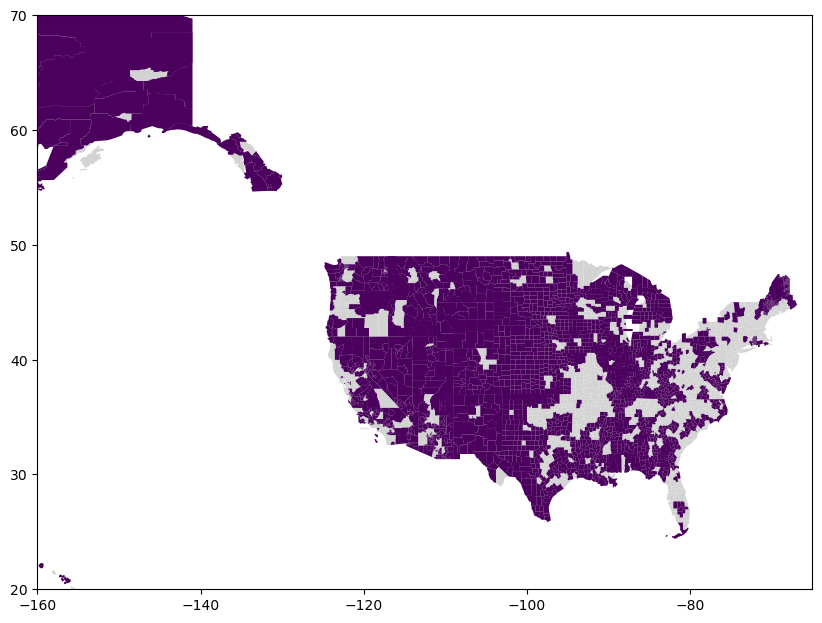

In [43]:
# how much of U.S. land has mental health HPSA geography designation?

fig, ax = plt.subplots()

counties.plot(ax=ax, color='#d3d3d3', zorder=0)
hpsa_boundaries.plot(ax=ax, color='#4B005E', zorder=1)

ax.set(xlim=(-160, -65), ylim=(20, 70));

- #### Go ahead and create unary unions from each dataset

In [44]:
# takes a minute
counties_unary = counties.unary_union
hpsa_boundaries_unary = hpsa_boundaries.unary_union
facilities_unary = facilities.unary_union

In [45]:
# get percentage of hpsa boundaries that 
print(f'{hpsa_boundaries_unary.area / counties_unary.area * 100}% of U.S. land has a mental health care professional shortage')

84.30432963750664% of U.S. land has a mental health care professional shortage


I think this is fine for preliminary/exploratory analysis, but if we were really going to report on this, we should probably overlay counties and hpsa_boundaries to make sure there aren't any funky spots where an HPSA boundary exists yet doesn't overlap with the U.S. counties file.

Also we would want to think about things such as the size of Alaska and its low population before reporting on this number.

- #### Add Mental Health HPSA Designated Facilities 

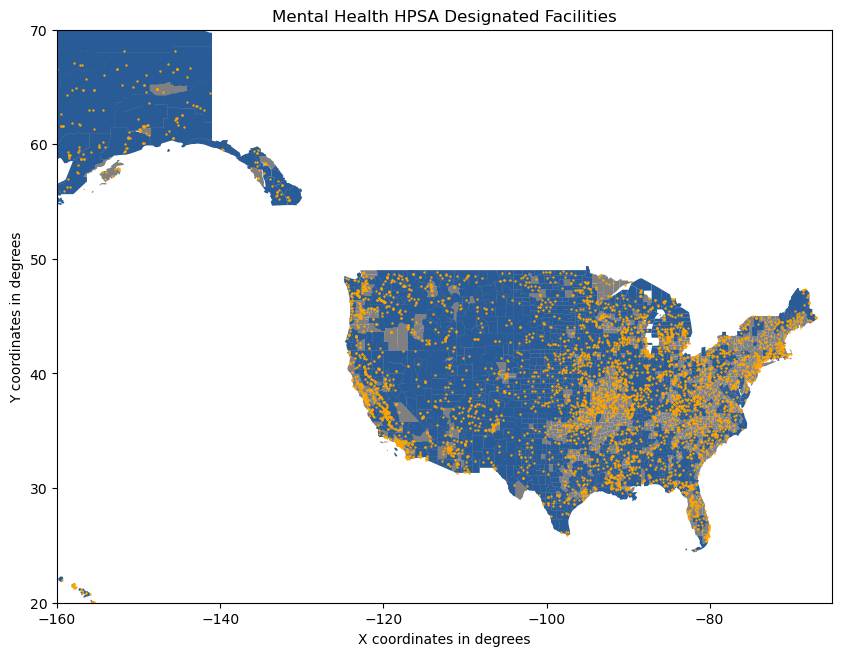

In [46]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

facilities.plot(ax=ax, color='orange', zorder=2, markersize=.5)
hpsa_boundaries.plot(ax=ax, color='#295b97', zorder=1);
counties.plot(ax=ax, color='gray', zorder=0);

ax.set(title='Mental Health HPSA Designated Facilities',
      xlabel='X coordinates in degrees',
      ylabel='Y coordinates in degrees')

ax.set(xlim=(-160, -65), ylim=(20, 70));

### Create new dataframe only of our counties of interest

These facilities are not HPSA designated due to their geographic locations. They may be designated due to an HPSA population, etc. This analysis is only focused on facilities that do fall within geographic HPSA boundaries.

- #### Clip facilities to only those that exist in hpsa boundaries

In [47]:
facilities = gpd.clip(facilities, hpsa_boundaries_unary)

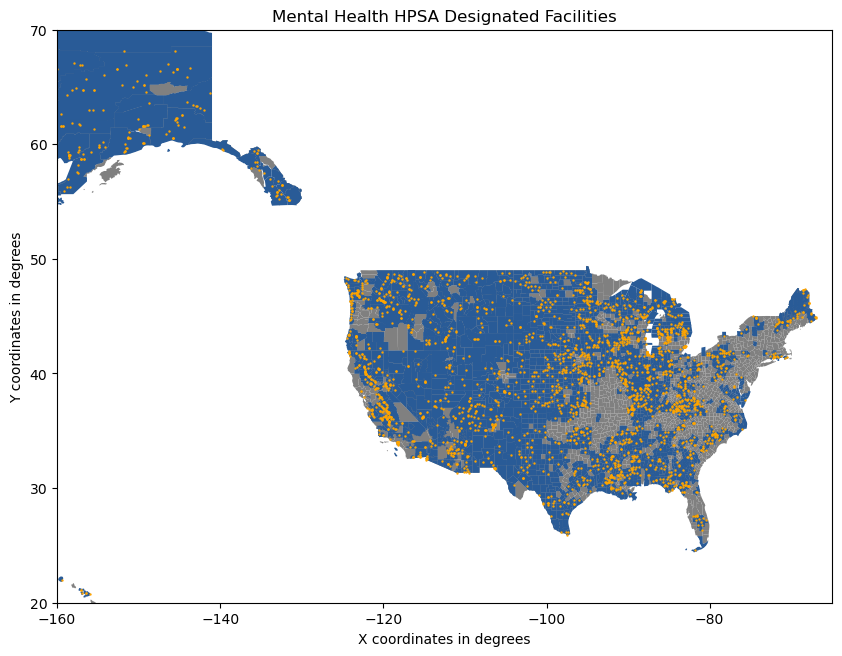

In [48]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

facilities.plot(ax=ax, color='orange', zorder=2, markersize=.5)
hpsa_boundaries.plot(ax=ax, color='#295b97', zorder=1);
counties.plot(ax=ax, color='gray', zorder=0);

ax.set(title='Mental Health HPSA Designated Facilities',
      xlabel='X coordinates in degrees',
      ylabel='Y coordinates in degrees')

ax.set(xlim=(-160, -65), ylim=(20, 70));

- #### Copy counties dataframe

In [49]:
rel_counties = counties.copy()
rel_counties.head()

,id,GEOID,NAME,STATEFP,geometry
0,0,37017,Bladen,37,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,1,37167,Stanly,37,"POLYGON ((-80.49737 35.20210, -80.29542 35.502..."
2,2,39153,Summit,39,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,3,42113,Sullivan,42,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,4,48459,Upshur,48,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."


- #### Find counties that overlap with HPSA regions

In [50]:
rel_counties = gpd.overlay(rel_counties, hpsa_boundaries, how="intersection", keep_geom_type=True)

/Users/courtcox/opt/miniconda3/envs/674_07/lib/python3.9/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():


In [51]:
rel_counties.geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [52]:
rel_counties.sample(5)

,id,GEOID,NAME,STATEFP,state,location_name,boundary_type,status,designation_type,hpsa_score,ratio,geometry
18106,1570,17031,Cook,17,Illinois,Chicago Central,Census Tract,Proposed For Withdrawal,Geographic HPSA,18,77988:1,"POLYGON ((-87.67463 41.80851, -87.67439 41.808..."
11268,2234,51021,Bland,51,Virginia,HN-Mount Rogers MHCA,Single County,Designated,High Needs Geographic HPSA,9,23719:1,"MULTIPOLYGON (((-81.40946 36.98287, -81.40831 ..."
2574,2593,17125,Mason,17,Illinois,Catchment Area 3-01-01,Single County,Proposed For Withdrawal,Geographic HPSA,15,57003:1,"MULTIPOLYGON (((-90.35053 40.12505, -90.35103 ..."
2791,92,48375,Potter,48,Texas,Oldham County,Single County,Designated,Geographic HPSA,10,None,"MULTIPOLYGON (((-102.16747 35.18323, -102.1674..."
15874,2996,12013,Calhoun,12,Florida,Big Bend MH Catchment Area Circuit 14,Single County,Designated,High Needs Geographic HPSA,15,35938:1,"MULTIPOLYGON (((-85.11566 30.19998, -85.11566 ..."


### Identify counties with correctional facilities

- #### Add identifier to relevant counties based on whether there is an hpsa correctional facility in the county

In [53]:
# create prisons dataframe

prisons = facilities[(facilities.designation_type == 'Correctional Facility')]

prisons = prisons.rename(columns={'location_name':'facility_name'})

prisons.sample(5)

,facility_name,HpsCity,state,status,designation_type,hpsa_score,HpsShtg,ratio,geometry
3696,State Correctional Institution - Somerset,Somerset,Pennsylvania,Proposed For Withdrawal,Correctional Facility,6,0.30,None,POINT (-79.04062 39.96130)
1054,Brooklyn Correctional Institution,Brooklyn,Connecticut,Designated,Correctional Facility,6,0.22,None,POINT (-71.95498 41.78567)
3846,South Dakota Women's Prison,Pierre,South Dakota,Designated,Correctional Facility,21,0.60,None,POINT (-100.30109 44.35452)
4436,Redgranite Correctional Institution,Redgranite,Wisconsin,Designated,Correctional Facility,12,0.73,None,POINT (-89.10484 44.05396)
3662,SCI Smithfield,Huntingdon,Pennsylvania,Proposed For Withdrawal,Correctional Facility,12,0.65,None,POINT (-78.03306 40.49823)


In [54]:
prisons_unary = prisons.geometry.unary_union

In [55]:
rel_counties['has_prison'] = rel_counties.intersects(prisons_unary)

In [56]:
rel_counties.geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

- #### Add identifier to relevant counties based on whether there is a non-prison

In [57]:
# create prisons dataframe

non_prisons = facilities[(facilities.designation_type != 'Correctional Facility')]

non_prisons.sample(5)

,facility_name,HpsCity,state,status,designation_type,hpsa_score,HpsShtg,ratio,geometry
1533,BELOVED COMMUNITY FAMILY WELLNESS CENTER,Chicago,Illinois,Designated,Federally Qualified Health Center,19,0.0,None,POINT (-87.64451 41.76995)
1546,LOUISIVILLE MEDICAL CLINIC,Louisville,Illinois,Designated,Rural Health Clinic,16,0.0,None,POINT (-88.50839 38.77250)
811,"Clinicas del Camino Real, Inc.",Ventura,California,Designated,Federally Qualified Health Center,21,0.0,None,POINT (-119.15969 34.29315)
439,Chinle Health Care Facility,Chinle,Arizona,Designated,"Indian Health Service, Tribal Health, and Urba...",20,0.0,None,POINT (-109.60366 36.28659)
3775,MCLEOD PEDIATRICS-DILLON,Dillon,South Carolina,Designated,Rural Health Clinic,19,0.0,None,POINT (-79.36372 34.42069)


In [58]:
non_prisons_unary = non_prisons.geometry.unary_union

In [59]:
rel_counties['has_non_prison'] = rel_counties.intersects(non_prisons_unary)

In [60]:
rel_counties.sample(1)

,id,GEOID,NAME,STATEFP,state,location_name,boundary_type,status,designation_type,hpsa_score,ratio,geometry,has_prison,has_non_prison
18190,1570,17031,Cook,17,Illinois,Chicago Central,Census Tract,Proposed For Withdrawal,Geographic HPSA,18,77988:1,"POLYGON ((-87.71454 41.84439, -87.71448 41.844...",False,False


- #### Identify counties that do have a prison but do not have a non-prison

In [61]:
def prison_only(row, one, two):  
    if row[one] == False and row[two] == True:
        return True
    return False

In [62]:
rel_counties['prison_only'] = rel_counties.apply(lambda rel_counties: prison_only(rel_counties, 'has_non_prison', 'has_prison'), axis=1)

rel_counties.prison_only.unique()

array([False,  True])

In [63]:
rel_counties = rel_counties[(rel_counties.prison_only == True)]

rel_counties.sample(5)

,id,GEOID,NAME,STATEFP,state,location_name,boundary_type,status,designation_type,hpsa_score,ratio,geometry,has_prison,has_non_prison,prison_only
5172,1625,13035,Butts,13,Georgia,MHCA 16 - McIntosh Trail Community Service Board,Single County,Designated,Geographic HPSA,5,30585:1,"POLYGON ((-84.08899 33.28565, -84.08899 33.285...",True,False,True
6031,2074,39129,Pickaway,39,Ohio,MHCA 52,Single County,Designated,Geographic HPSA,13,42102:1,"POLYGON ((-83.25102 39.71443, -83.25102 39.714...",True,False,True
8299,728,17101,Lawrence,17,Illinois,Choate MHCA,Single County,Designated,Geographic HPSA,18,85008:1,"MULTIPOLYGON (((-87.91229 38.57010, -87.91229 ...",True,False,True
8893,3058,48163,Frio,48,Texas,Frio County,Single County,Designated,High Needs Geographic HPSA,20,62228:1,"POLYGON ((-99.24829 29.09109, -99.24799 29.091...",True,False,True
4266,153,51159,Richmond,51,Virginia,Middle Peninsula/Northern Neck MHCA,Single County,Designated,High Needs Geographic HPSA,14,77656:1,"POLYGON ((-76.87706 38.12436, -76.86800 38.114...",True,False,True


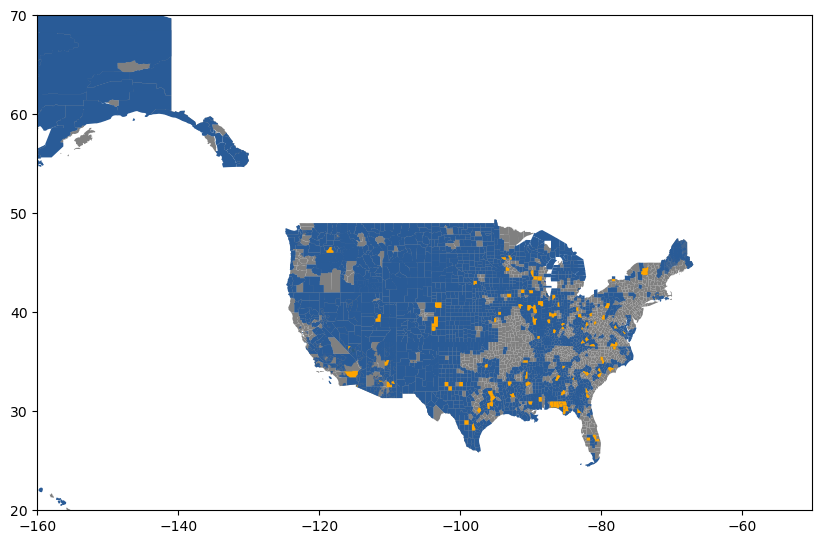

In [64]:
# visualize the boundaries where there is an hpsa correctional facility but no other type of hpsa facility
fig, ax = plt.subplots()

rel_counties.plot(ax=ax, color='orange', zorder=2, markersize=.5)
hpsa_boundaries.plot(ax=ax, color='#295b97', zorder=1);
counties.plot(ax=ax, color='gray', zorder=0);

ax.set(xlim=(-160, -50), ylim=(20, 70));

- #### Let's check how many of our boundaries are county boundaries.

In [65]:
rel_counties.groupby(['boundary_type']).size()

boundary_type
Census Tract           28
County Subdivision      4
Single County         118
dtype: int64

In [66]:
# are there are any duplicated GEOIDs (where perhaps a census tract was identified within a county)?

rel_counties['duplicate_geoid'] = rel_counties.duplicated(subset=['GEOID'])

In [67]:
rel_counties[(rel_counties.duplicate_geoid == True)]

,id,GEOID,NAME,STATEFP,state,location_name,boundary_type,status,designation_type,hpsa_score,ratio,geometry,has_prison,has_non_prison,prison_only,duplicate_geoid
1444,1645,18153,Sullivan,18,Indiana,Sullivan County,Single County,Proposed For Withdrawal,High Needs Geographic HPSA,19,None,"POLYGON ((-87.63846 39.16811, -87.63793 39.168...",True,False,True,True
2819,725,48471,Walker,48,Texas,MCHA 37 - Tri County,Single County,Designated,High Needs Geographic HPSA,7,24982:1,"POLYGON ((-95.85869 30.86553, -95.85862 30.865...",True,False,True,True
3046,2687,17057,Fulton,17,Illinois,Fulton County,Single County,Designated,Geographic HPSA,17,None,"POLYGON ((-90.44732 40.49276, -90.44723 40.495...",True,False,True,True
3072,2330,18121,Parke,18,Indiana,Vermillion/Parke Counties,Single County,Proposed For Withdrawal,Geographic HPSA,17,None,"POLYGON ((-87.38914 39.95250, -87.38756 39.952...",True,False,True,True
4367,2623,48001,Anderson,48,Texas,MHCA 1 - ACCESS,Single County,Designated,Geographic HPSA,16,53792:1,"MULTIPOLYGON (((-95.36486 31.73681, -95.36505 ...",True,False,True,True
4552,163,27131,Rice,27,Minnesota,South Central Region,Single County,Proposed For Withdrawal,Geographic HPSA,16,290840:1,"POLYGON ((-93.50231 44.54367, -93.50223 44.543...",True,False,True,True
4982,448,17105,Livingston,17,Illinois,McLean/Livingston Counties,Single County,Proposed For Withdrawal,Geographic HPSA,8,41767:1,"POLYGON ((-88.25150 41.11422, -88.25146 41.113...",True,False,True,True
5690,3039,04009,Graham,04,Arizona,Safford,Census Tract,Designated,Geographic HPSA,20,None,"POLYGON ((-109.45283 33.01624, -109.45075 33.0...",True,False,True,True
6031,2074,39129,Pickaway,39,Ohio,MHCA 52,Single County,Designated,Geographic HPSA,13,42102:1,"POLYGON ((-83.25102 39.71443, -83.25102 39.714...",True,False,True,True
6492,1644,19111,Lee,19,Iowa,Southeast Counties,Single County,Designated,Geographic HPSA,14,45199:1,"POLYGON ((-91.42523 40.81294, -91.42298 40.812...",True,False,True,True


In [68]:
# let's go ahead and remove anything with a boundary type that isn't Single County

rel_counties = rel_counties[(rel_counties.boundary_type == 'Single County')]

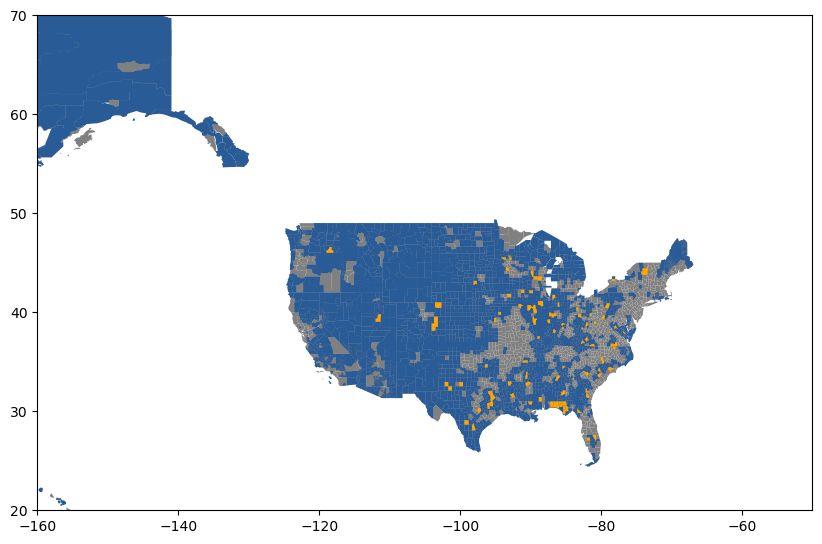

In [69]:
fig, ax = plt.subplots()

rel_counties.plot(ax=ax, color='orange', zorder=2, markersize=.5)
hpsa_boundaries.plot(ax=ax, color='#295b97', zorder=1);
counties.plot(ax=ax, color='gray', zorder=0);

ax.set(xlim=(-160, -50), ylim=(20, 70));

In [70]:
# drop anything else with a duplicate geoID

rel_counties = rel_counties[(rel_counties.duplicate_geoid) == False]

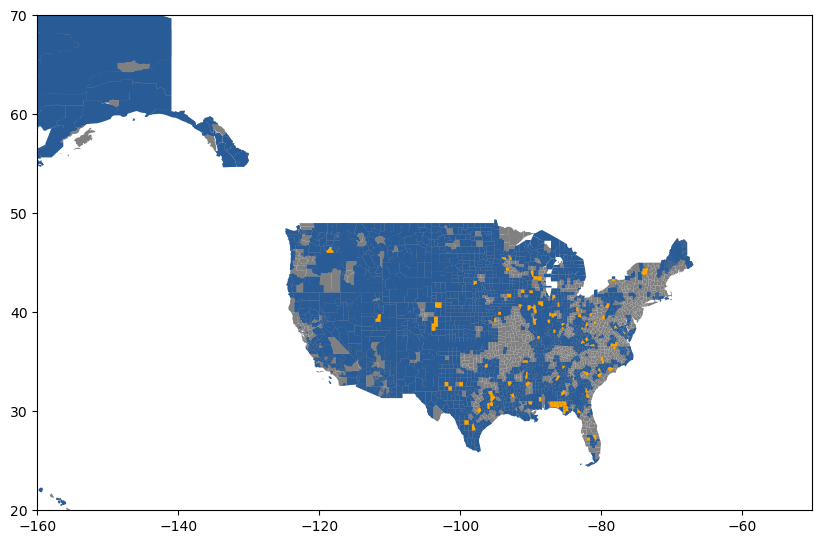

In [71]:
fig, ax = plt.subplots()

rel_counties.plot(ax=ax, color='orange', zorder=2, markersize=.5)
hpsa_boundaries.plot(ax=ax, color='#295b97', zorder=1);
counties.plot(ax=ax, color='gray', zorder=0);

ax.set(xlim=(-160, -50), ylim=(20, 70));

In [72]:
rel_counties.describe()

,hpsa_score
count,97.000000
mean,15.443299
std,3.013750
min,5.000000
25%,14.000000
50%,15.000000
75%,18.000000
max,21.000000


In [73]:
rel_counties.state.unique()

array(['North Carolina', 'West Virginia', 'Indiana', 'Texas', 'Florida',
       'Georgia', 'Virginia', 'Alabama', 'Minnesota', 'Illinois',
       'South Carolina', 'Colorado', 'Kentucky', 'Ohio', 'Iowa',
       'Mississippi', 'Wisconsin', 'Kansas', 'Louisiana', 'Arkansas',
       'Missouri', 'South Dakota', 'Utah', 'New York', 'Oklahoma',
       'Washington', 'Pennsylvania'], dtype=object)

In [74]:
# which Kentucky county?

ky = rel_counties[(rel_counties.state == 'Kentucky')]

ky

,id,GEOID,NAME,STATEFP,state,location_name,boundary_type,status,designation_type,hpsa_score,ratio,geometry,has_prison,has_non_prison,prison_only,duplicate_geoid
5699,212,21019,Boyd,21,Kentucky,Pathways MHCA,Single County,Proposed For Withdrawal,High Needs Geographic HPSA,11,27041:1,"POLYGON ((-82.80831 38.39530, -82.80823 38.395...",True,False,True,False
7628,2071,21185,Oldham,21,Kentucky,Oldham County,Single County,Designated,High Needs Geographic HPSA,18,62308:1,"POLYGON ((-85.58975 38.44853, -85.58603 38.450...",True,False,True,False
9632,3043,21115,Johnson,21,Kentucky,Mountain MHCA,Single County,Designated,High Needs Geographic HPSA,14,33857:1,"MULTIPOLYGON (((-82.64075 37.72018, -82.64075 ...",True,False,True,False


Overall I think this is fine, but I am slightly suspicious of some of the data quality here due to the inconsistencies in the location names. Some are county names, whereas some are locations names, despite being a full "single county" boundary type. This would be something to look into further and possibly contact HRSA if actually reporting on this.

### Prepare export data

- #### Reassign variable and clean up county column

In [75]:
export_data = rel_counties[['NAME', 'state', 'GEOID', 'geometry']].copy()

In [76]:
export_data['NAME'] = (export_data['NAME'] + ' County').astype(str)

export_data = export_data.rename(columns={'NAME': 'county'})

In [77]:
export_data.sample(5)

,county,state,GEOID,geometry
9039,Montgomery County,Illinois,17135,"POLYGON ((-89.53365 39.52459, -89.53224 39.436..."
4544,Rice County,Minnesota,27131,"POLYGON ((-93.50231 44.54367, -93.50223 44.543..."
1683,Mecklenburg County,Virginia,51117,"MULTIPOLYGON (((-78.56689 36.64002, -78.56554 ..."
2096,Okeechobee County,Florida,12093,"POLYGON ((-81.14060 27.60436, -81.14041 27.604..."
15796,Essex County,New York,36031,"POLYGON ((-74.25600 43.96980, -74.25600 43.969..."


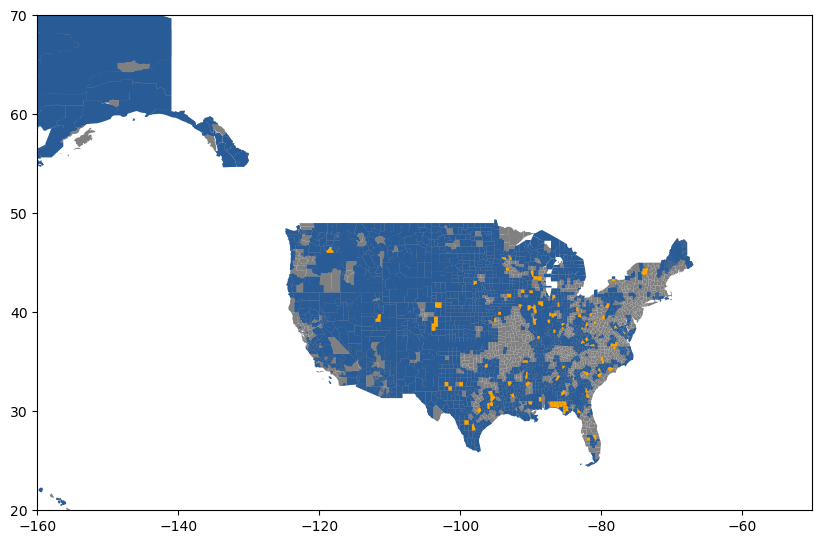

In [86]:
fig, ax = plt.subplots()

export_data.plot(ax=ax, color='orange', zorder=2, markersize=.5)
hpsa_boundaries.plot(ax=ax, color='#295b97', zorder=1);
counties.plot(ax=ax, color='gray', zorder=0);

ax.set(xlim=(-160, -50), ylim=(20, 70));

- #### Simplify export data for smaller file sizes

In [96]:
with open('data/hpsa_prison_only.json', 'w') as f:
    f.write(export_data.to_json())

- #### Rewrite hpsa_boundaries geojson

In [97]:
with open('data/hpsa_boundaries.json', 'w') as f:
    f.write(hpsa_boundaries.to_json())

- #### Remove hpsa_facilities file

In [89]:
if os.path.exists('data/hpsa_facilities.json'):
  os.remove('data/hpsa_facilities.json')
else:
  print('hpsa_facilities file does not exist') 

- #### Use subprocess module to run mapshaper commands to reduce file sizes.

In [101]:
subprocess.run(["mapshaper", 
                "data/hpsa_prison_only.json", 
                "-clean", 
                "-simplify", "1.7%", 
                "-o", "force", "precision=0.00001", "data/hpsa_prison_only.json"])

[clean] Removed 178 / 236 slivers using 0.088+ sqkm variable threshold
[clean] Retained 97 of 97 features
[o] Wrote data/hpsa_prison_only.json


CompletedProcess(args=['mapshaper', 'data/hpsa_prison_only.json', '-clean', '-simplify', '1.7%', '-o', 'force', 'precision=0.00001', 'data/hpsa_prison_only.json'], returncode=0)

In [102]:
subprocess.run(["mapshaper", 
                "data/hpsa_boundaries.json", 
                "-clean", 
                "-simplify", "1.7%", 
                "-o", "force", "precision=0.00001", "data/hpsa_boundaries.json"])

[clean] Removed 1 / 63 sliver using 0.034+ sqkm variable threshold
[clean] Retained 5,895 of 7,248 features
[simplify] Repaired 10 intersections
[o] Wrote data/hpsa_boundaries.json


CompletedProcess(args=['mapshaper', 'data/hpsa_boundaries.json', '-clean', '-simplify', '1.7%', '-o', 'force', 'precision=0.00001', 'data/hpsa_boundaries.json'], returncode=0)

In [104]:
subprocess.run(["mapshaper", 
                "data/counties-20m.json", 
                "-clean", 
                "-simplify", "1.7%",
                "-o", "force", "precision=0.00001", "data/counties-20m.json"])

[clean] Retained 3,220 of 3,220 features
[simplify] Repaired 4 intersections
[o] Wrote data/counties-20m.json


CompletedProcess(args=['mapshaper', 'data/counties-20m.json', '-clean', '-simplify', '1.7%', '-o', 'force', 'precision=0.00001', 'data/counties-20m.json'], returncode=0)

You could now remove the files from the .gitignore.